In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy import stats
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
#old_pipeline_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/fatalities002_2024_12_t01_cm.csv'
old_pipeline_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/simple_ensembles.parquet'
new_pipeline_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/predictions_forecasting_20250218_192439.parquet'
shapefile_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/ne_110m_admin_0_countries.shp'
historical_data_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/forecasting_viewser_df.parquet'


In [3]:
#df_old = pd.read_csv(old_pipeline_path)
df_iso = pd.read_csv('/home/sonja/Desktop/VSC_projects/pipeline-comparison/fatalities002_2024_12_t01_cm.csv')
df_old = pd.read_parquet(old_pipeline_path, engine='pyarrow')
df_new = pd.read_parquet(new_pipeline_path, engine='pyarrow')
df_shape = gpd.read_file(shapefile_path)
df_hist = pd.read_parquet(historical_data_path, engine='pyarrow')

In [4]:
df_old.reset_index(inplace=True)
df_old.describe()

,c_id,month_id,ens_mean_log,ens_median_log,ens_mean_exp,ens_median_exp,nomarkov_mean_log,nomarkov_median_log,nomarkov_mean_exp,nomarkov_median_exp
count,6876.000000,6876.00000,6876.000000,6876.000000,6876.000000,6876.000000,6876.000000,6876.000000,6876.000000,6876.000000
mean,108.675393,559.50000,0.591935,0.571100,6.781118,5.120748,0.586265,0.567823,5.798068,4.942404
std,66.195791,10.38905,1.148503,1.155145,27.773167,18.470167,1.134474,1.147073,21.561598,17.338610
min,1.000000,542.00000,0.007447,0.003691,0.007599,0.003697,0.007788,0.003691,0.008060,0.003697
25%,50.000000,550.75000,0.018223,0.009277,0.018955,0.009320,0.018224,0.009259,0.018911,0.009303
50%,109.000000,559.50000,0.047759,0.018801,0.051859,0.018979,0.046871,0.017756,0.050882,0.017915
75%,158.000000,568.25000,0.353358,0.307292,0.490046,0.359741,0.347186,0.302709,0.487045,0.353691
max,246.000000,577.00000,6.228788,6.062767,814.914454,428.562448,6.066313,5.986913,614.878268,398.301879


In [5]:
df_new.reset_index(inplace=True)
df_new.describe()

,month_id,country_id,step_combined
count,6876.00000,6876.000000,6876.000000
mean,558.50000,108.675393,0.659884
std,10.38905,66.195791,1.332386
min,541.00000,1.000000,0.000146
25%,549.75000,50.000000,0.011870
50%,558.50000,109.000000,0.051242
75%,567.25000,158.000000,0.383975
max,576.00000,246.000000,8.315930


In [6]:
df_old = df_old.rename(columns={"c_id": "country_id"})
df_old = df_old.rename(columns={"country_name": "country"})
df_old.head()

,country,country_id,month_id,ens_mean_log,ens_median_log,ens_mean_exp,ens_median_exp,nomarkov_mean_log,nomarkov_median_log,nomarkov_mean_exp,nomarkov_median_exp
0,Guyana,1,542,0.012941,0.005409,0.013435,0.005424,0.011420,0.005307,0.011901,0.005321
1,Suriname,2,542,0.011526,0.005636,0.011971,0.005652,0.010927,0.005409,0.011396,0.005424
2,Trinidad and Tobago,3,542,0.011693,0.005636,0.012055,0.005652,0.011355,0.005636,0.011733,0.005652
3,Venezuela,4,542,0.070380,0.026040,0.084888,0.026383,0.070809,0.026040,0.086421,0.026383
4,Samoa,5,542,0.015503,0.005640,0.016190,0.005655,0.016595,0.005640,0.017350,0.005655


In [7]:
# Some preprocessing

def merge_dataframes(df_old, df_new):
        """
        Processes df_new and df_old and merge it into one dataframe df_merged.

        Returns:
        The combined dataframe including the predictions from the old and new pipeline.
        """

        df_merged = df_old.merge(df_new, how='inner', on=['month_id', 'country_id'])
        df_merged['step_combined_noln']=np.exp(df_merged['step_combined'])-1
        df_merged = df_merged.loc[:, ~df_merged.columns.str.startswith('surrogate')]

        return df_merged

def select_country_id(df, df_hist, id):

        df_id = df[df['country_id']==id]
        df_hist = df_hist.reset_index()
        #print(df_old.head())
        df_hist_id=df_hist[df_hist['country_id']==id]
        df_hist_id=df_hist_id[df_hist_id['month_id']>=500]
        df_hist_id['ged_sb_dep'] = np.exp(df_hist_id['ln_ged_sb_dep']) - 1
        df_hist_id = df_hist_id[['month_id', 'country_id', 'ln_ged_sb_dep', 'ged_sb_dep']]

        return df_id, df_hist_id

def get_country_id(df, name):
        
        id = df[df['country']==name]['country_id'].unique()[0]
        #df_hist = df_hist.reset_index()
        #print(df_old.head())
        #df_hist_id=df_hist[df_hist['country']==name]
        #df_hist_id=df_hist_id[df_hist_id['month_id']>=500]
        #df_hist_id['ged_sb_dep'] = np.exp(df_hist_id['ln_ged_sb_dep']) - 1
        #df_hist_id = df_hist_id[['month_id', 'country_id', 'ln_ged_sb_dep', 'ged_sb_dep']]

        return id

def select_month_id(df, id):

        df_merged_id = df[df['month_id']==id]

        return df_merged_id

def calculate_date_from_index(target_index, start_index = 121, start_date = '01.1990'):
        """
        Calculates the month-year date for a given target index based on the start index and start date.

        Parameters:
        start_index (int): The index corresponding to the start date.
        start_date (str): The start date in 'MM.YYYY' format.
        target_index (int): The index for which the month-year date is required.

        Returns:
        str: The calculated month-year date corresponding to the target_index in 'MM.YYYY' format.
        """
        # Convert the start date to a datetime object
        base_date = datetime.strptime(start_date, '%m.%Y')
    
        # Calculate the difference in indices
        month_difference = target_index - start_index
    
        # Calculate the target date by adding the month difference
        target_date = base_date + relativedelta(months=month_difference)
    
        return target_date.strftime('%m.%Y')

def prepare_historical_data(df_hist):
        df_old = df_hist.reset_index()
        df_old["date"] = df_old["month_id"].apply(calculate_date_from_index)
        df_old[["month", "year"]] = df_old["date"].str.split(".", expand=True)
        df_old = df_old[df_old['month_id']>=500]

        return df_old

def aggregate_countries(df, df_hist):
        df_aggregated = df.groupby(['year', 'month'])[['nomarkov_mean_exp', 'step_combined_noln']].sum().reset_index()
        df_hist_aggregated = df_hist.groupby(['year', 'month'])[['ged_sb_dep']].sum().reset_index()
        df_aggregated['nomarkov_mean_log']= np.log(df_aggregated['nomarkov_mean_exp'])+1
        df_hist_aggregated['ln_ged_sb_dep'] = np.log(df_hist_aggregated['ged_sb_dep'])+1
        df_aggregated['step_combined'] = np.log(df_aggregated['step_combined_noln'])+1

        return df_aggregated, df_hist_aggregated


def aggregate_all_predictions(df):

        df_aggregated = df.groupby(['country_id'], as_index=False).agg({'step_combined_noln':'sum', 'nomarkov_mean_exp': 'sum','isoab': 'first'})

        return df_aggregated

def corr_predictions(df, col_namea, col_nameb):
        """
        Takes one dataframe including the predictions from the old and new pipeline and calculates the Pearson, Kendall and Spearman correlation.

        Returns:
        list: A list with the Pearson[0], Kendall[1] and Spearman[2] correlation coefficients 
        
        """
        corr_pearson = df[col_namea].corr(df[col_nameb], method='pearson')
        corr_kendall = df[col_namea].corr(df[col_nameb], method='kendall')
        corr_spearman = df[col_namea].corr(df[col_nameb], method='spearman')
        print(f"Pearson correlation: {corr_pearson:.4f}")
        print(f"Kendall correlation: {corr_kendall:.4f}")
        print(f"Spearman correlation: {corr_spearman:.4f}")
    
        return [corr_pearson, corr_kendall, corr_spearman]


def calculate_distance(df, col_namea, col_nameb):
        """
        Takes one dataframe including the predictions from the old and new pipeline and calculates the Jensen-Shannon divergence, the Kullback-Leibler divergence, 
        the Wasserstein distance as well as the Kolmogorov-Smirnov Test.

        Returns:
        list: A list with the Jensen-Shannon divergence [0], the Wasserstein distance [1] as well as the Kolmogorov-Smirnov Test [2].
        
        """
        ks = stats.kstest(df[col_namea], df[col_nameb])
        js_div = distance.jensenshannon(df[col_namea], df[col_nameb])
        ws_dis = wasserstein_distance(df[col_namea], df[col_nameb])
        #kl_a_b = entropy(df[col_namea], df[col_nameb])
        #kl_b_a = entropy(df[col_nameb], df[col_namea])
        print(f"Jensen-Shannon Divergence: {js_div:.4f}")  # Square it to get the actual JSD
        print(f"Wasserstein Distance: {ws_dis:.4f}")
        print(f"Kolmogorov-Smirnov: {ks}")

        return [js_div, ws_dis, ks]
    
def calculate_cosine_similarity(df, col_namea, col_nameb):
        """
        Takes one dataframe including the predictions from the old and new pipeline and calculates the cosine similarity.

        Returns: 'numpy.float64' object

        """
        data_a = df[col_namea].dropna().values.reshape(1, -1)
        data_b = df[col_nameb].dropna().values.reshape(1, -1)

        # Calculate the cosine similarity
        similarity = cosine_similarity(data_a, data_b)[0][0]
        print(f"Cosine Similarity: {similarity:.4f}")

        return similarity

def plot_predictions(df_hist_id, df, log=None):
        """
        Plots the predictions from the old and new pipeline over the forecast horizon for a specific country

        Returns:
        a plot
        
        """
        if log == True:
            col_hist='ln_ged_sb_dep'
            #col_old_preds = 'main_mean_ln'
            col_old_preds = 'nomarkov_mean_log'
            col_new_preds = 'step_combined'
            title = 'Predicted Log Fatalities Over Time'
            ylabel = 'Predicted Fatalities (log)'

        else:
            col_hist='ged_sb_dep'
            #col_old_preds = 'main_mean'
            col_old_preds = 'nomarkov_mean_exp'
            col_new_preds = 'step_combined_noln'
            title = 'Predicted Fatalities Over Time'
            ylabel = 'Predicted Fatalities '


        if 'month_id' in df.columns: 
            time_index=df['month_id']
            time_index_hist = df_hist_id['month_id']
            x_vert = 540
        elif 'month' in df.columns:
            df['date'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
            time_index=df['date']
            df_hist_id['date'] = df_hist_id['year'].astype(str) + '-' + df_hist_id['month'].astype(str).str.zfill(2)
            time_index_hist=df_hist_id['date']
            x_vert = '2024-12'

        else:
            print('The provided dataframe does not have a valid time index')
        # plt.clf()
        plt.figure(figsize=(10,6))
        plt.plot(time_index_hist, df_hist_id[col_hist], 
        color='grey', marker='o', linestyle='-', linewidth=1, markersize=3, label='historical data')
        plt.plot(time_index, df[col_old_preds], 
        color='dodgerblue', marker='o', linestyle='-', linewidth=1, markersize=3, label='old pipeline')
        plt.plot(time_index, df[col_new_preds], 
         color='red', marker='o', linestyle='-', linewidth=1, markersize=3, label='new pipeline')
        plt.axvline(x=x_vert, color='black', linestyle='--', linewidth=0.9)

        plt.title(title, fontsize=16, fontweight='bold')
        plt.xlabel('Forecast Horizon', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.xticks(rotation=90) 
        plt.tight_layout()
        plt.legend(title='Legend', fontsize=10)

        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

def map_predictions(df, df_shape, log=None):
        df_geo = df_shape.merge(df, left_on='SOV_A3', right_on='isoab', how='left')

        if log == True:
            col_old_preds = 'main_mean_ln'
            col_new_preds = 'step_combined'
            title = 'Comparison of Predicted Log Fatalities Between Old and New Pipeline'

        else:
            col_old_preds = 'main_mean'
            col_new_preds = 'step_combined_noln'
            title = 'Comparison of Predicted Fatalities Between Old and New Pipeline'
        #fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        #df_geo.boundary.plot(ax=ax, linewidth=1)
        #df_geo.plot(column=colname, ax=ax, legend=True, 
        #    legend_kwds={'label': "Value by Country",
        #                 'orientation': "horizontal"},
        #    cmap='OrRd')

        #plt.title(f"World Map of {colname} by Country")
        #plt.show()

        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
        vmin = min(df_geo[col_old_preds].min(), df_geo[col_new_preds].min())
        vmax = max(df_geo[col_old_preds].max(), df_geo[col_new_preds].max())

        df_geo.boundary.plot(ax=ax1, linewidth=0.7)
        ax1 = df_geo.plot(column=col_old_preds, ax=ax1, legend=True, 
            legend_kwds={'label': "Value by Country - Old pipeline",
                         'orientation': "horizontal"},
            cmap='OrRd', vmin=vmin, vmax=vmax)
        df_geo.boundary.plot(ax=ax2, linewidth=0.7)
        ax2 = df_geo.plot(column=col_new_preds, ax=ax2, legend=True, 
            legend_kwds={'label': "Value by Country - New pipeline",
                         'orientation': "horizontal"},
            cmap='OrRd', vmin=vmin, vmax=vmax)
        fig.suptitle(title, fontsize=20, fontweight='bold')
        plt.show()



In [8]:
df_merged = df_old.merge(df_new, how='inner', on=['month_id', 'country_id'])
df_merged['step_combined_noln']=np.exp(df_merged['step_combined'])-1
df_merged.head()

,country,country_id,month_id,ens_mean_log,ens_median_log,ens_mean_exp,ens_median_exp,nomarkov_mean_log,nomarkov_median_log,nomarkov_mean_exp,nomarkov_median_exp,step_combined,step_combined_noln
0,Guyana,1,542,0.012941,0.005409,0.013435,0.005424,0.011420,0.005307,0.011901,0.005321,0.004736,0.004748
1,Suriname,2,542,0.011526,0.005636,0.011971,0.005652,0.010927,0.005409,0.011396,0.005424,0.001767,0.001769
2,Trinidad and Tobago,3,542,0.011693,0.005636,0.012055,0.005652,0.011355,0.005636,0.011733,0.005652,0.010768,0.010826
3,Venezuela,4,542,0.070380,0.026040,0.084888,0.026383,0.070809,0.026040,0.086421,0.026383,0.026959,0.027325
4,Samoa,5,542,0.015503,0.005640,0.016190,0.005655,0.016595,0.005640,0.017350,0.005655,0.001401,0.001402


In [9]:
#df_iso = df_iso[['country_id', 'isoab']]
country_iso_mapping = df_iso[['country_id', 'isoab']].drop_duplicates().set_index('country_id')['isoab'].to_dict()

In [10]:
df_merged['isoab'] = df_merged['country_id'].map(country_iso_mapping)

In [11]:
df_merged.describe()

,country_id,month_id,ens_mean_log,ens_median_log,ens_mean_exp,ens_median_exp,nomarkov_mean_log,nomarkov_median_log,nomarkov_mean_exp,nomarkov_median_exp,step_combined,step_combined_noln
count,6685.000000,6685.00000,6685.000000,6685.000000,6685.000000,6685.000000,6685.000000,6685.000000,6685.000000,6685.000000,6685.000000,6685.000000
mean,108.675393,559.00000,0.592412,0.571665,6.847209,5.166961,0.586736,0.568384,5.839749,4.984827,0.660094,16.278646
std,66.195928,10.10026,1.151306,1.157972,28.081280,18.653837,1.137144,1.149760,21.762275,17.503918,1.325208,130.506513
min,1.000000,542.00000,0.007447,0.003691,0.007599,0.003697,0.007788,0.003691,0.008060,0.003697,0.000146,0.000146
25%,50.000000,550.00000,0.018142,0.009215,0.018809,0.009258,0.018099,0.009172,0.018752,0.009215,0.012574,0.012653
50%,109.000000,559.00000,0.047443,0.018513,0.051295,0.018685,0.046514,0.017357,0.050700,0.017509,0.053274,0.054719
75%,158.000000,568.00000,0.352200,0.304786,0.487758,0.356523,0.345531,0.299340,0.484848,0.349141,0.390591,0.477854
max,246.000000,576.00000,6.228788,6.062767,814.914454,428.562448,6.066313,5.986913,614.878268,398.301879,8.274937,3923.273714


In [12]:
df_iso[['main_mean', 'main_mean_ln']].describe()

,main_mean,main_mean_ln
count,6876.000000,6876.000000
mean,28.454528,0.790662
std,157.455320,1.584024
min,-0.001300,-0.001300
25%,0.017400,0.017300
50%,0.055950,0.054450
75%,0.594825,0.466800
max,3868.941800,8.261000


In [13]:
#df_merged_subold = df_merged[df_merged['main_mean']>=10]
df_merged_subold = df_merged[df_merged['nomarkov_mean_exp']>=10]
df_merged_subnew = df_merged[df_merged['step_combined_noln']>=10]


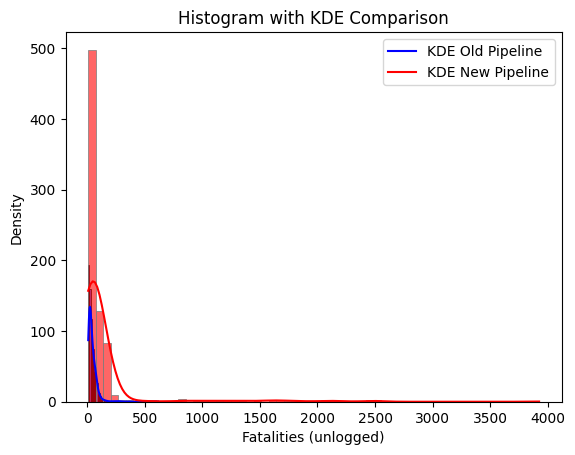

In [14]:
#ax = sns.histplot(df_merged_subold['main_mean'], bins=60, kde=True, color="blue", alpha=0.6, edgecolor="black")
ax = sns.histplot(df_merged_subold['nomarkov_mean_exp'], bins=60, kde=True, color="blue", alpha=0.6, edgecolor="black")
ax = sns.histplot(df_merged_subnew['step_combined_noln'], bins=60, kde=True, color="red", alpha=0.6, edgecolor="grey")

# Manually set KDE labels
ax.lines[0].set_label("KDE Old Pipeline")
ax.lines[1].set_label("KDE New Pipeline")

# Show legend
plt.legend()
# Show plot
plt.xlabel("Fatalities (unlogged)")
plt.ylabel("Density")
plt.title("Histogram with KDE Comparison")
plt.show()

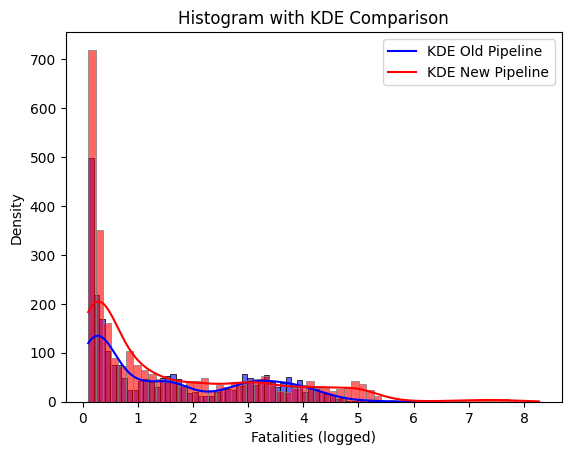

In [15]:
#df_merged_subold = df_merged[df_merged['main_mean']>0.3]
#df_merged_subnew = df_merged[df_merged['step_combined_noln']>0.3]
#ax = sns.histplot(df_merged_subold['main_mean_ln'], bins=60, kde=True, color="blue", alpha=0.6, edgecolor="black")
df_merged_subold = df_merged[df_merged['nomarkov_mean_log']>0.1]
df_merged_subnew = df_merged[df_merged['step_combined']>0.1]

ax = sns.histplot(df_merged_subold['nomarkov_mean_log'], bins=60, kde=True, color="blue", alpha=0.6, edgecolor="black")
ax = sns.histplot(df_merged_subnew['step_combined'], bins=60, kde=True, color="red", alpha=0.6, edgecolor="grey")

# Manually set KDE labels
ax.lines[0].set_label("KDE Old Pipeline")
ax.lines[1].set_label("KDE New Pipeline")

# Show legend
plt.legend()
# Show plot
plt.xlabel("Fatalities (logged)")
plt.ylabel("Density")
plt.title("Histogram with KDE Comparison")
plt.show()

In [16]:
df_merged.sort_values(by=['nomarkov_mean_exp'], ascending=False)[['country', 'month_id', 'nomarkov_mean_log']]

,country,month_id,nomarkov_mean_log
103,Ukraine,542,6.066313
676,Ukraine,545,5.080578
176,Israel,542,5.670293
294,Ukraine,543,5.439069
485,Ukraine,544,5.179362
...,...,...,...
6592,Finland,576,0.007788
86,Denmark,542,0.008043
35,Iceland,542,0.008022
95,Switzerland,542,0.007923


In [17]:
df_merged.sort_values(by=['step_combined_noln'], ascending=False)[['country', 'month_id', 'step_combined_noln']]

,country,month_id,step_combined_noln
103,Ukraine,542,3923.273714
2013,Ukraine,552,2513.824385
1822,Ukraine,551,2492.680735
2395,Ukraine,554,2467.693224
1631,Ukraine,550,2467.626184
...,...,...,...
4901,Brunei,567,0.001000
4553,Timor Leste,565,0.000990
6463,Timor Leste,575,0.000735
5146,Montenegro,568,0.000523


In [18]:
corrs = corr_predictions(df_merged, 'nomarkov_mean_exp', 'step_combined_noln')

Pearson correlation: 0.5867
Kendall correlation: 0.6506
Spearman correlation: 0.8137


In [19]:
sim = calculate_cosine_similarity(df_merged, 'nomarkov_mean_exp', 'step_combined_noln')

Cosine Similarity: 0.5943


In [20]:
distances =calculate_distance(df_merged, 'nomarkov_mean_exp', 'step_combined_noln')

Jensen-Shannon Divergence: 0.3912
Wasserstein Distance: 10.6402
Kolmogorov-Smirnov: KstestResult(statistic=0.22782348541510844, pvalue=1.9579818211226193e-152, statistic_location=0.012287725984253539, statistic_sign=-1)


In [21]:
df_month = select_month_id(df_merged, 542)
df_month.head()

,country,country_id,month_id,ens_mean_log,ens_median_log,ens_mean_exp,ens_median_exp,nomarkov_mean_log,nomarkov_median_log,nomarkov_mean_exp,nomarkov_median_exp,step_combined,step_combined_noln,isoab
0,Guyana,1,542,0.012941,0.005409,0.013435,0.005424,0.011420,0.005307,0.011901,0.005321,0.004736,0.004748,GUY
1,Suriname,2,542,0.011526,0.005636,0.011971,0.005652,0.010927,0.005409,0.011396,0.005424,0.001767,0.001769,SUR
2,Trinidad and Tobago,3,542,0.011693,0.005636,0.012055,0.005652,0.011355,0.005636,0.011733,0.005652,0.010768,0.010826,TTO
3,Venezuela,4,542,0.070380,0.026040,0.084888,0.026383,0.070809,0.026040,0.086421,0.026383,0.026959,0.027325,VEN
4,Samoa,5,542,0.015503,0.005640,0.016190,0.005655,0.016595,0.005640,0.017350,0.005655,0.001401,0.001402,WSM


(-198.0, 198.00000000000006, -98.6822565, 92.3273865)

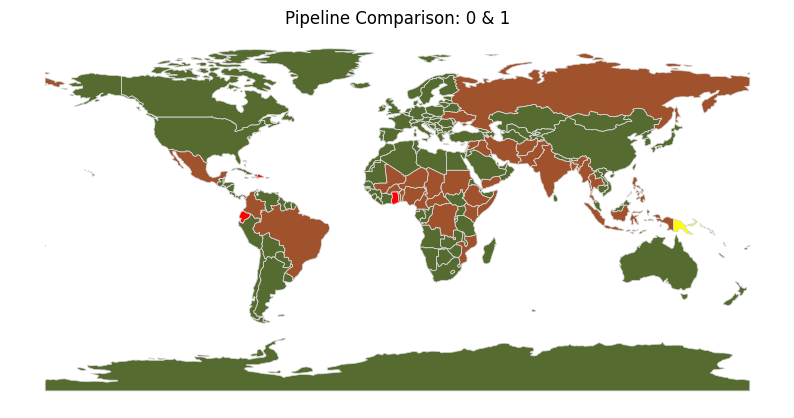

In [22]:
# Filter only the "Both 0" condition
df_geo = df_shape.merge(df_month, left_on='SOV_A3', right_on='isoab', how='left')

df_geo["old_binary"] = (df_geo["nomarkov_mean_exp"] >= 1).astype(int)
df_geo["new_binary"] = (df_geo["step_combined_noln"] >= 1).astype(int)

both_zero = df_geo[(df_geo["old_binary"] == 0) & (df_geo["new_binary"] == 0)]
both_one = df_geo[(df_geo["old_binary"] == 1) & (df_geo["new_binary"] == 1)]
one_zero = df_geo[(df_geo["old_binary"] == 1) & (df_geo["new_binary"] == 0)]
zero_one = df_geo[(df_geo["old_binary"] == 0) & (df_geo["new_binary"] == 1)]

# Plot world map
fig, ax = plt.subplots(figsize=(10, 6))
#df_geo.plot(ax=ax, color="lightgray", edgecolor="black")
df_geo.boundary.plot(ax=ax, color="lightgray", linewidth=0.5)

# Plot data points where both old and new predictions are 0
both_zero.plot(ax=ax, color="darkolivegreen", markersize=50)
both_one.plot(ax=ax, color="sienna", markersize=50)
one_zero.plot(ax=ax, color="red", markersize=50)
zero_one.plot(ax=ax, color="yellow", markersize=50)

# Customize plot
ax.set_title("Pipeline Comparison: 0 & 1")
#ax.legend()
ax.axis("off")

#plt.show()

In [ ]:
# Look at individual countries

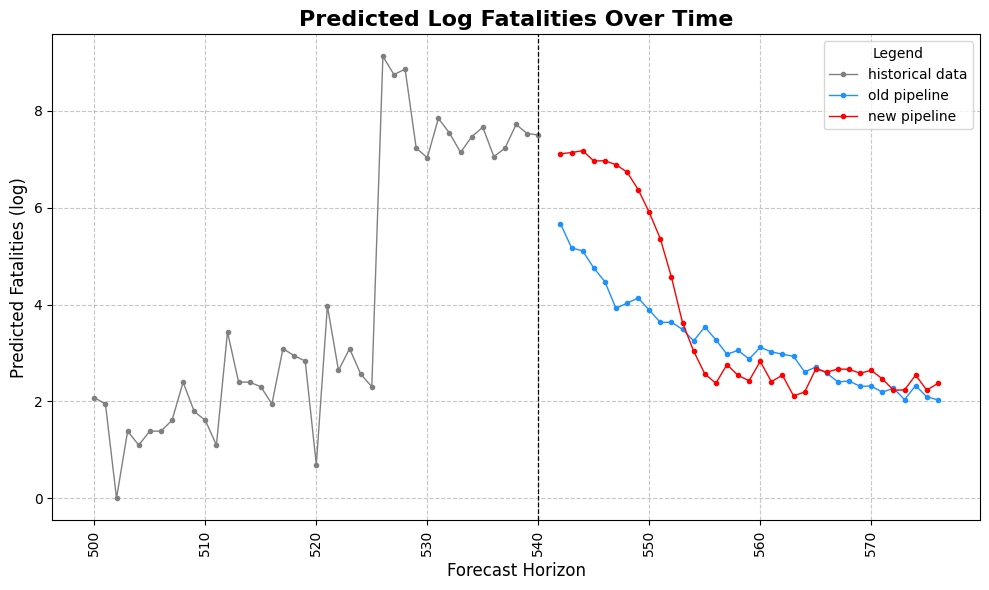

In [23]:
df_id, df_hist_id = select_country_id(df_merged, df_hist, get_country_id(df_merged, name='Israel'))
plot_predictions(df_hist_id, df_id, log=True)

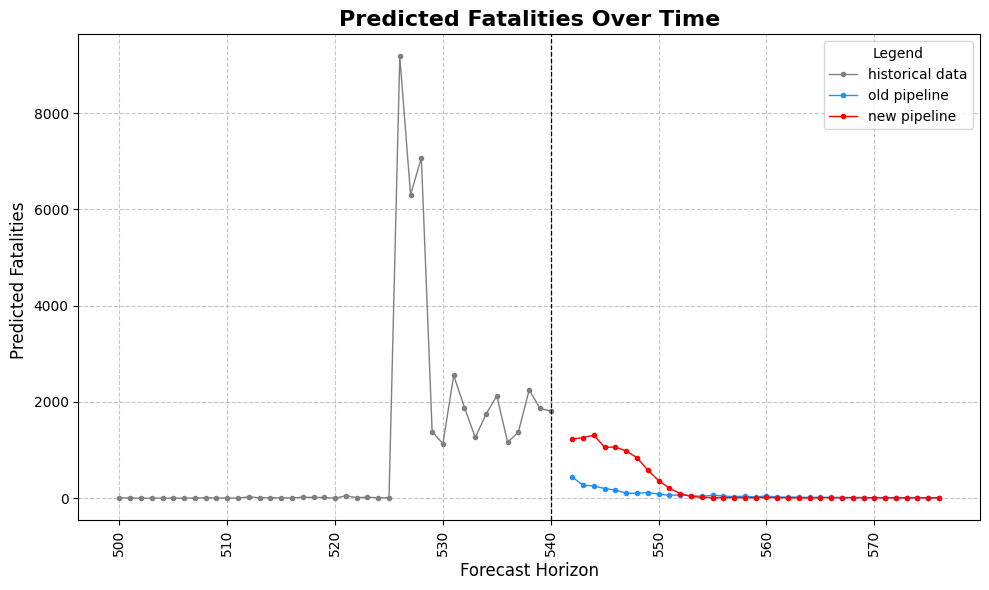

In [24]:
plot_predictions(df_hist_id, df_id, log=False)

In [25]:
corrs = corr_predictions(df_id, 'nomarkov_mean_exp', 'step_combined_noln')

Pearson correlation: 0.8918
Kendall correlation: 0.6235
Spearman correlation: 0.7952


In [26]:
sim = calculate_cosine_similarity(df_id, 'nomarkov_mean_exp', 'step_combined_noln')

Cosine Similarity: 0.9201


In [27]:
distances = calculate_distance(df_id, 'nomarkov_mean_exp', 'step_combined_noln')

Jensen-Shannon Divergence: 0.2647
Wasserstein Distance: 211.9157
Kolmogorov-Smirnov: KstestResult(statistic=0.4, pvalue=0.0068714202633811654, statistic_location=13.418139278153477, statistic_sign=-1)


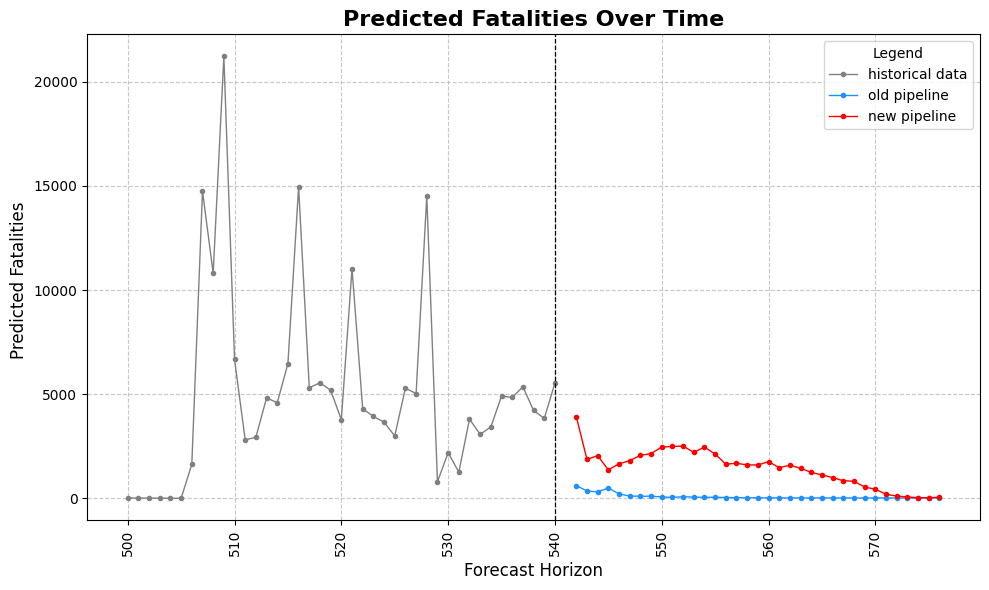

In [28]:
df_id, df_hist_id = select_country_id(df_merged, df_hist, get_country_id(df_merged, name='Ukraine'))
plot_predictions(df_hist_id, df_id, log=False)

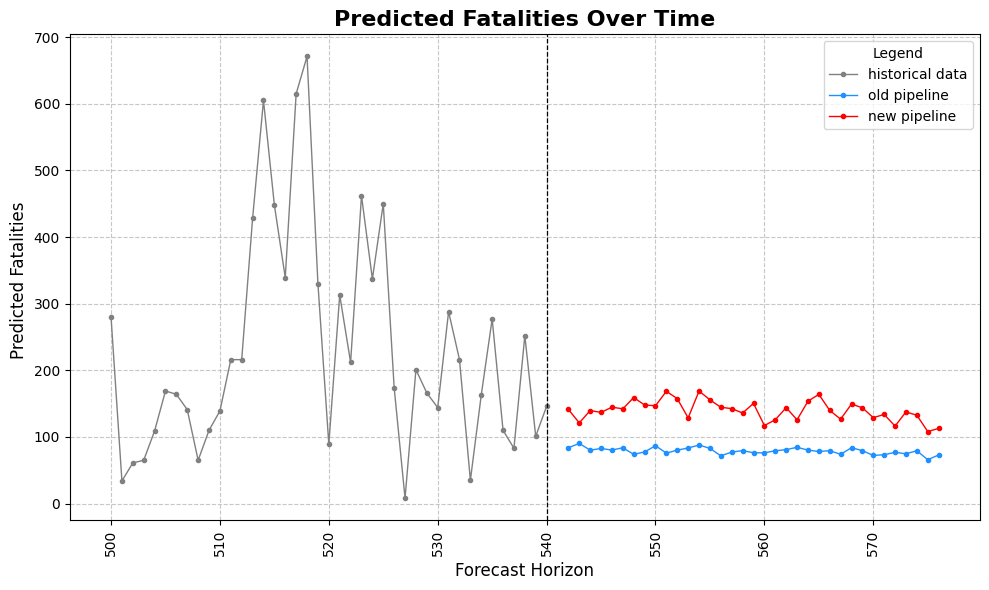

In [29]:
df_id, df_hist_id = select_country_id(df_merged, df_hist, get_country_id(df_merged, name='Somalia'))
plot_predictions(df_hist_id, df_id, log=False)

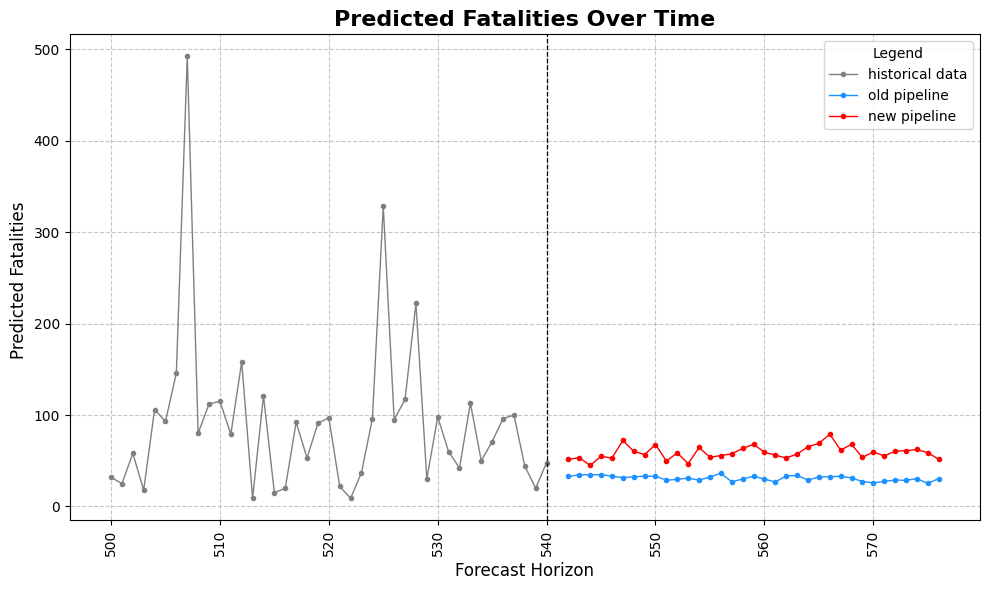

In [30]:
df_id, df_hist_id = select_country_id(df_merged, df_hist, get_country_id(df_merged, name='Mali'))
plot_predictions(df_hist_id, df_id, log=False)

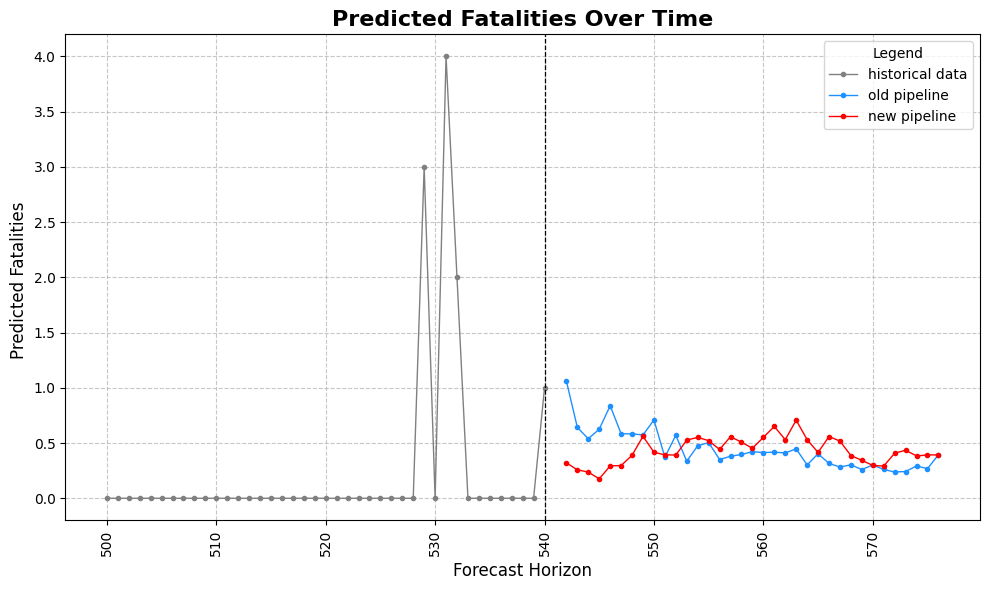

In [31]:
df_id, df_hist_id = select_country_id(df_merged, df_hist, get_country_id(df_merged, name='Ecuador'))
plot_predictions(df_hist_id, df_id, log=False)

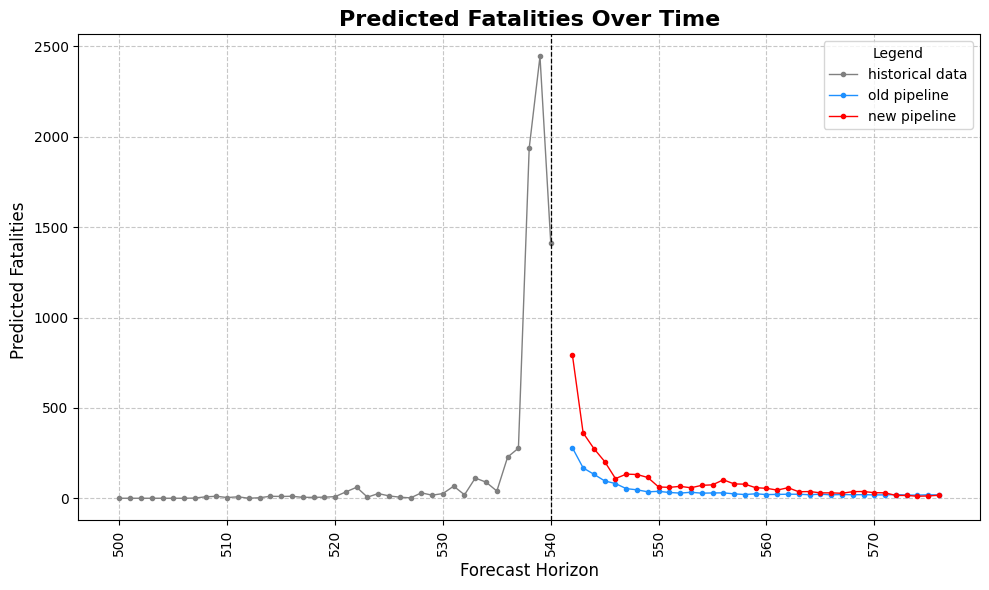

In [32]:
df_id, df_hist_id = select_country_id(df_merged, df_hist, get_country_id(df_merged, name='Russia'))
plot_predictions(df_hist_id, df_id, log=False)

In [33]:
# Aggregations

In [34]:
df_all = aggregate_all_predictions(df_merged)
df_all.head()

,country_id,step_combined_noln,nomarkov_mean_exp,isoab
0,1,2.940591,1.106101,GUY
1,2,2.186717,1.033244,SUR
2,3,2.035630,1.523975,TTO
3,4,7.297781,15.611609,VEN
4,5,1.150639,0.647879,WSM


In [35]:
df_all['nomarkov_mean_log'] = np.log(df_all['nomarkov_mean_exp'])+1
df_all['step_combined'] = np.log(df_all['step_combined_noln'])+1

In [36]:
df_all.head()

,country_id,step_combined_noln,nomarkov_mean_exp,isoab,nomarkov_mean_log,step_combined
0,1,2.940591,1.106101,GUY,1.100841,2.078611
1,2,2.186717,1.033244,SUR,1.032703,1.782401
2,3,2.035630,1.523975,TTO,1.421322,1.710805
3,4,7.297781,15.611609,VEN,3.748015,2.987570
4,5,1.150639,0.647879,WSM,0.565948,1.140317


In [37]:
df_all.sort_values(by=['nomarkov_mean_exp'], ascending=False)

,country_id,step_combined_noln,nomarkov_mean_exp,isoab,nomarkov_mean_log,step_combined
103,117,50563.077113,3215.954357,UKR,9.075879,11.830977
122,136,3801.334338,2884.980165,PAK,8.967273,9.243107
106,120,4891.638226,2765.154310,SOM,8.924852,9.495283
69,79,5199.779590,2570.279996,NGA,8.851770,9.556372
189,245,3897.645214,2537.080942,SDN,8.838769,9.268128
...,...,...,...,...,...,...
156,171,0.609487,0.536823,NZL,0.377914,0.504863
97,111,0.073542,0.514316,EST,0.335083,-1.609898
95,109,0.536674,0.510800,CHE,0.328223,0.377636
180,231,0.120045,0.510261,MNE,0.327167,-1.119886


In [38]:
df_all.sort_values(by=['step_combined_noln'], ascending=False)

,country_id,step_combined_noln,nomarkov_mean_exp,isoab,nomarkov_mean_log,step_combined
103,117,50563.077113,3215.954357,UKR,9.075879,11.830977
176,218,9301.275972,2484.787617,ISR,8.817942,10.137907
177,220,5858.924075,2118.210657,SYR,8.658327,9.675721
69,79,5199.779590,2570.279996,NGA,8.851770,9.556372
106,120,4891.638226,2765.154310,SOM,8.924852,9.495283
...,...,...,...,...,...,...
126,140,0.052755,0.597527,BRN,0.485044,-1.942102
129,144,0.051539,0.554989,PLW,0.411192,-1.965411
138,153,0.050660,0.573633,FSM,0.444234,-1.982624
137,152,0.050032,0.585658,MHL,0.464981,-1.995091


In [39]:
df_all.describe()

,country_id,step_combined_noln,nomarkov_mean_exp,nomarkov_mean_log,step_combined
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,108.675393,569.752615,204.391224,2.732463,2.751909
std,66.364935,3801.895830,589.092055,2.546942,2.805111
min,1.000000,0.046351,0.503663,0.314152,-2.071504
25%,51.000000,0.939765,0.730192,0.685286,0.937759
50%,109.000000,2.314776,1.999562,1.692928,1.839313
75%,157.500000,18.588559,16.708095,3.815890,3.922542
max,246.000000,50563.077113,3215.954357,9.075879,11.830977


In [40]:
corrs = corr_predictions(df_all, 'nomarkov_mean_exp', 'step_combined_noln')
sim = calculate_cosine_similarity(df_all, 'nomarkov_mean_exp', 'step_combined_noln')
distances = calculate_distance(df_all, 'nomarkov_mean_exp', 'step_combined_noln')

Pearson correlation: 0.5981
Kendall correlation: 0.6865
Spearman correlation: 0.8355
Cosine Similarity: 0.6075
Jensen-Shannon Divergence: 0.3511
Wasserstein Distance: 381.8163
Kolmogorov-Smirnov: KstestResult(statistic=0.13089005235602094, pvalue=0.07577888424411738, statistic_location=0.5366741592750841, statistic_sign=-1)


In [392]:
# Aggregate countries over country_id

In [41]:
df_hist_prep = prepare_historical_data(df_hist)
df_hist_prep['ged_sb_dep'] = np.exp(df_hist_prep['ln_ged_sb_dep']) - 1
df_merged["date"] = df_merged["month_id"].apply(calculate_date_from_index)
df_merged[["month", "year"]] = df_merged["date"].str.split(".", expand=True)
df_aggrgated, df_hist_agregated = aggregate_countries(df_merged, df_hist_prep)

In [42]:
df_aggrgated.describe()

,nomarkov_mean_exp,step_combined_noln,nomarkov_mean_log,step_combined
count,35.000000,35.000000,35.000000,35.000000
mean,1115.392107,3109.221411,7.961767,8.926364
std,446.700632,1476.790007,0.310764,0.504232
min,800.662389,1125.616478,7.685439,8.026086
25%,865.546229,2004.597002,7.763330,8.603165
50%,914.561841,2941.787699,7.818445,8.986773
75%,1141.057296,4165.920943,8.039479,9.334687
max,2812.554988,7818.493056,8.941849,9.964247


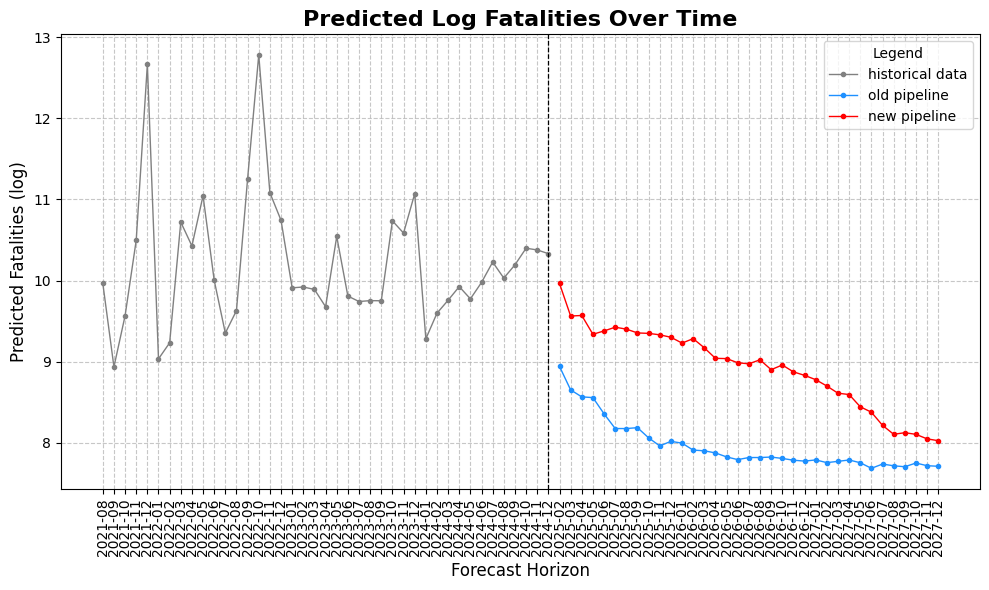

In [43]:
plot_predictions(df_hist_agregated, df_aggrgated, log=True)

#### PRIO GRID CELLS #####

In [44]:
old_pipeline_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/fatalities002_2024_12_t01_pgm.csv'
new_pipeline_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/predictions_forecasting_pgm.parquet'
shapefile_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/priogrid_cell.shp'
#historical_data_path = '/home/sonja/Desktop/VSC_projects/pipeline-comparison/forecasting_viewser_df.parquet'


In [45]:
pgm_old = pd.read_csv(old_pipeline_path)
pgm_new = pd.read_parquet(new_pipeline_path, engine='pyarrow')

In [46]:
pgm_old.rename(columns={"pg_id": "priogrid_id"}, inplace=True)
pgm_old.head()

,priogrid_id,month_id,main_mean_ln,main_mean,main_dich
0,62356,541,0.0001,0.0001,0.0062
1,79599,541,0.0001,0.0001,0.0062
2,79600,541,0.0002,0.0002,0.0062
3,79601,541,0.0002,0.0002,0.0062
4,80317,541,0.0002,0.0002,0.0062


In [47]:
pgm_new.reset_index(inplace=True)
pgm_new.describe()


,month_id,priogrid_id,pred_ln_ged_sb_dep
count,471960.000000,471960.000000,471960.000000
mean,558.500000,144794.092982,0.012767
std,10.388306,26708.183388,0.080927
min,541.000000,62356.000000,-0.032161
25%,549.750000,126436.000000,0.000301
50%,558.500000,149457.500000,0.000735
75%,567.250000,166012.000000,0.002521
max,576.000000,190511.000000,5.590536


In [48]:
pgm_merged = pgm_old.merge(pgm_new, how='inner', on=['priogrid_id', 'month_id'])

In [49]:
pgm_merged['pred_ged_sb_dep']= np.exp(pgm_merged['pred_ln_ged_sb_dep'])-1

In [50]:
pgm_merged.describe()

,priogrid_id,month_id,main_mean_ln,main_mean,main_dich,pred_ln_ged_sb_dep,pred_ged_sb_dep
count,471960.000000,471960.000000,471960.000000,471960.000000,471960.000000,471960.000000,471960.000000
mean,144794.092982,558.500000,0.095180,0.322933,0.132080,0.012767,0.023100
std,26708.183388,10.388306,0.351793,4.099107,0.310011,0.080927,0.881995
min,62356.000000,541.000000,-0.000400,-0.000400,0.006000,-0.032161,-0.031649
25%,126436.000000,549.750000,0.000500,0.000500,0.006900,0.000301,0.000301
50%,149457.500000,558.500000,0.002100,0.002100,0.007600,0.000735,0.000736
75%,166012.000000,567.250000,0.017100,0.017200,0.015000,0.002521,0.002524
max,190511.000000,576.000000,6.038500,418.256000,1.000000,5.590536,266.879276


In [51]:
corrs = corr_predictions(pgm_merged, 'main_mean_ln', 'pred_ln_ged_sb_dep')

Pearson correlation: 0.6489
Kendall correlation: 0.5503
Spearman correlation: 0.7298


In [52]:
corrs = corr_predictions(pgm_merged, 'main_mean', 'pred_ged_sb_dep')

Pearson correlation: 0.4197
Kendall correlation: 0.5503
Spearman correlation: 0.7298


In [53]:
sim = calculate_cosine_similarity(pgm_merged, 'main_mean', 'pred_ged_sb_dep')

Cosine Similarity: 0.4203


In [54]:
distances = calculate_distance(pgm_merged, 'main_mean', 'pred_ged_sb_dep')

Jensen-Shannon Divergence: inf
Wasserstein Distance: 0.2998
Kolmogorov-Smirnov: KstestResult(statistic=0.2334265615730146, pvalue=0.0, statistic_location=0.0015999419238135193, statistic_sign=-1)


In [55]:
threshold = 0.5
pgm_merged_subold = pgm_merged[pgm_merged['main_mean']>=threshold]
pgm_merged_subnew = pgm_merged[pgm_merged['pred_ged_sb_dep']>=threshold]

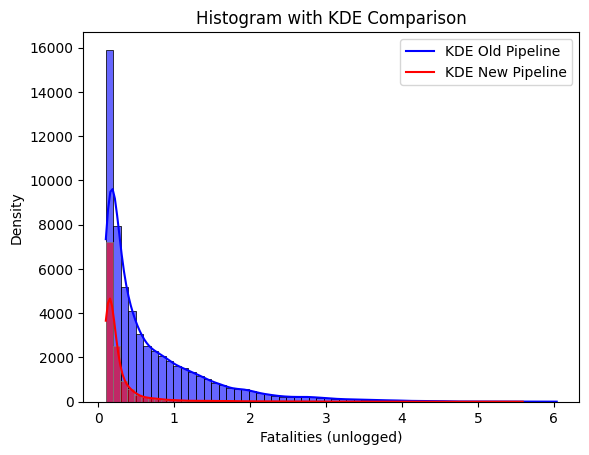

In [56]:
threshold = 0.1
pgm_merged_subold = pgm_merged[pgm_merged['main_mean_ln']>=threshold]
pgm_merged_subnew = pgm_merged[pgm_merged['pred_ln_ged_sb_dep']>=threshold]

ax = sns.histplot(pgm_merged_subold['main_mean_ln'], bins=60, kde=True, color="blue", alpha=0.6, edgecolor="black")
ax = sns.histplot(pgm_merged_subnew['pred_ln_ged_sb_dep'], bins=60, kde=True, color="red", alpha=0.6, edgecolor="grey")

# Manually set KDE labels
ax.lines[0].set_label("KDE Old Pipeline")
ax.lines[1].set_label("KDE New Pipeline")

# Show legend
plt.legend()
# Show plot
plt.xlabel("Fatalities (unlogged)")
plt.ylabel("Density")
plt.title("Histogram with KDE Comparison")
plt.show()

In [57]:
pgm_merged[['month_id', 'priogrid_id', 'main_mean', 'pred_ged_sb_dep']].sort_values(by=['main_mean'], ascending=False)

,month_id,priogrid_id,main_mean,pred_ged_sb_dep
37911,543,175390,418.2560,4.863796
38230,543,177552,404.2934,20.471399
77241,546,175390,399.8712,5.596010
38026,543,176111,392.5508,2.994407
25120,542,177552,391.6360,22.137797
...,...,...,...,...
2977,541,122871,-0.0003,0.000684
2978,541,122872,-0.0003,0.000255
2477,541,116373,-0.0004,0.000275
2478,541,116374,-0.0004,0.000275


In [58]:
pgm_merged[['month_id', 'priogrid_id', 'main_mean', 'pred_ged_sb_dep']].sort_values(by=['pred_ged_sb_dep'], ascending=False)

,month_id,priogrid_id,main_mean,pred_ged_sb_dep
11564,541,174669,259.0268,266.879276
77114,546,174669,314.3534,208.751222
37784,543,174669,318.4281,194.102541
90224,547,174669,159.8735,168.689854
50894,544,174669,256.8734,164.673355
...,...,...,...,...
344210,567,127164,6.5575,-0.015515
426900,573,153787,1.4453,-0.016177
383540,570,127164,7.6413,-0.021556
362141,568,158046,1.8649,-0.023355
